In [50]:
# Librerias
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx

**FUNCIONES**

In [37]:
############
# Función para graficar el árbol
def mod_bin_arbol(S, K, r, sigma, u, d, T, N, opcion):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)
    q = 1 - p

    precio_accion = [[0] * (N + 1) for _ in range(N + 1)]
    valor_opcion = [[0] * (N + 1) for _ in range(N + 1)]

    for i in range(N + 1):
        for j in range(i + 1):
            precio_accion[j][i] = S * (u ** (i - j)) * (d ** j)
            if opcion == "call":
                valor_opcion[j][i] = max(precio_accion[j][i] - K, 0)
            else:
                valor_opcion[j][i] = max(K - precio_accion[j][i], 0)


    G = nx.DiGraph()
    pos = {}

    for i in range(N + 1):
        for j in range(i + 1):
            etiqueta_nodo = f"{precio_accion[j][i]:.2f}\n{valor_opcion[j][i]:.2f}"
            G.add_node((j, i), label=etiqueta_nodo)
            pos[(j, i)] = (i, -j)

    for i in range(N):
        for j in range(i + 1):
            G.add_edge((j, i), (j, i + 1), label='u')
            G.add_edge((j, i), (j + 1, i + 1), label='d')

    valor = val_gral(S, K, r, sigma, u, d, T, N, tipo, opcion)


    plt.figure(figsize=(12, 8))
    etiquetas_aristas = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_size=700, node_color='skyblue',
            font_size=8, font_color='black', font_weight='bold', edge_color='gray', width=1.5, alpha=0.8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=etiquetas_aristas, font_color='red', font_size=8, font_weight='bold')
    plt.title(f'Valor de la opcion: {opcion} {tipo} es {valor:.3f} \n u = {u:.3f} d = {d:.3f} p = {p:.3f}')
    plt.show()

    return valor_opcion[0][0]


In [39]:
############
# Modelo binomial Europeo Sigma
def mod_bin_s(S, K, r, sigma, T, N, opcion):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)
    q = 1 - p
    precio_accion = [0] * (N + 1)
    valor_opcion = [0] * (N + 1)

    for i in range(N + 1):
        precio_accion[i] = S * (u ** (N - i)) * (d ** i)
        if opcion == "call":
            valor_opcion[i] = max(precio_accion[i] - K, 0)
        else:
            valor_opcion[i] = max(K - precio_accion[i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            valor_opcion[i] = math.exp(-r * dt) * (p * valor_opcion[i] + q * valor_opcion[i + 1])
            precio_accion[i] = precio_accion[i] / u

    return valor_opcion[0]


In [4]:
############
# Modelo binomial Europeo UD
def mod_bin_ud(S, K, r, u, d, T, N, opcion):
    dt = T / N
    p = (math.exp(r * dt) - d) / (u - d)
    q = 1 - p
    precio_accion = [0] * (N + 1)
    valor_opcion = [0] * (N + 1)

    for i in range(N + 1):
        precio_accion[i] = S * (u ** (N - i)) * (d ** i)
        if opcion == "call":
            valor_opcion[i] = max(precio_accion[i] - K, 0)
        else:
            valor_opcion[i] = max(K - precio_accion[i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            valor_opcion[i] = math.exp(-r * dt) * (p * valor_opcion[i] + q * valor_opcion[i + 1])
            precio_accion[i] = precio_accion[i] / u

    return valor_opcion[0]


In [5]:
############
# Modelo binomial Americana Sigma
def op_am_s(S, K, r, sigma, T, N, opcion):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    S_t = np.zeros((N + 1, N + 1))
    V_t = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            S_t[j, i] = S * (u ** (i - j)) * (d ** j)
            if i == N:
                if opcion == 'call':
                    V_t[j, i] = max(S_t[j, i] - K, 0)
                else:
                    V_t[j, i] = max(K - S_t[j, i], 0)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            V_t[j, i] = np.exp(-r * dt) * (p * V_t[j, i + 1] + (1 - p) * V_t[j + 1, i + 1])
            if opcion == 'call':
                V_t[j, i] = max(V_t[j, i], S_t[j, i] - K)
            else:
                V_t[j, i] = max(V_t[j, i], K - S_t[j, i])
    return V_t[0, 0]


In [6]:
############
# Modelo binomial Americana ud
def op_am_ud(S, K, r, u, d, T, N, opcion):
    dt = T / N
    p = (np.exp(r * dt) - d) / (u - d)
    S_t = np.zeros((N + 1, N + 1))
    V_t = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            S_t[j, i] = S * (u ** (i - j)) * (d ** j)
            if i == N:
                if opcion == 'call':
                    V_t[j, i] = max(S_t[j, i] - K, 0)
                else:
                    V_t[j, i] = max(K - S_t[j, i], 0)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            V_t[j, i] = np.exp(-r * dt) * (p * V_t[j, i + 1] + (1 - p) * V_t[j + 1, i + 1])
            if opcion == 'call':
                V_t[j, i] = max(V_t[j, i], S_t[j, i] - K)
            else:
                V_t[j, i] = max(V_t[j, i], K - S_t[j, i])
    return V_t[0, 0]


In [7]:
def val_gral(S, K, r, sigma, u, d, T, N, tipo, opcion):
    if tipo == 'europea':
        if sigma != 0:
            precio_opcion = mod_bin_s(S, K, r, sigma, T, N, opcion)
        else:
            precio_opcion = mod_bin_ud(S, K, r, u, d, T, N, opcion)
    else:
        if sigma != 0:
            precio_opcion = op_am_s(S, K, r, sigma, T, N, opcion)
        else:
            precio_opcion = op_am_ud(S, K, r, u, d, T, N, opcion)

    return precio_opcion


In [8]:
#########
# Ecuación de paridad para modelo binomial.
def paridad_check_mb(S, K, r, sigma, u, d, T, N, opcion):

  if sigma != 0:
    call_precio = mod_bin_s(S, K, r, sigma, T, N, 'call')
    put_precio = mod_bin_s(S, K, r, sigma, T, N, 'put')

    paridad_put = call_precio + K*math.exp(-r*T) - S
    paridad_call = put_precio + S - K*math.exp(-r*T)

  else:
    call_precio = mod_bin_ud(S, K, r, u, d, T, N, 'call')
    put_precio = mod_bin_ud(S, K, r, u, d, T, N, 'put')

    paridad_put = call_precio + K*math.exp(-r*T) - S
    paridad_call = put_precio + S - K*math.exp(-r*T)


  datos_paridad = ['Call', 'Put', 'Paridad Call', 'Paridad Put']
  valores_paridad = [call_precio, put_precio, paridad_call, paridad_put]
  data_paridad = {'Datos' : datos_paridad, 'Valores' : valores_paridad}

  df_paridad = pd.DataFrame(data_paridad)

  if opcion == 'put':
      if math.isclose(call_precio, paridad_call, rel_tol=1e-2, abs_tol=1e-2):
          print(f'Call calculado: {call_precio:.5f}')
          print(f'Call calculado con ecuación de paridad: {paridad_call:.5f}')
          print("La ecuación de paridad se cumple.")
      else:
          print("La ecuación de paridad NO se cumple.")
  else:
      if math.isclose(put_precio, paridad_put, rel_tol=1e-2, abs_tol=1e-2):
          print(f'Put calculado con modelo binomial: {put_precio:.5f}')
          print(f'Put calculado con ecuación de paridad: {paridad_put:.5f}')
          print("La ecuación de paridad se cumple.")
      else:
          print("La ecuación de paridad NO se cumple.")

  return df_paridad


In [9]:
###########
# Modelo Black&Scholes
def black_scholes(S, K, T, r, sigma, opcion):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    if opcion == "call":
        valor_opcion = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif opcion == "put":
        valor_opcion = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return valor_opcion


In [10]:
#########
# Ecuación de paridad para Black & Scholes
def paridad_check_bs(S, K, T, r, sigma):

  call_precio_bs = black_scholes(S, K, T, r, sigma, 'call')
  put_precio_bs = black_scholes(S, K, T, r, sigma, 'put')

  paridad_put = call_precio_bs + K*math.exp(-r*T) - S
  paridad_call = put_precio_bs + S - K*math.exp(-r*T)

  datos_paridad = ['Call', 'Put', 'Paridad Call', 'Paridad Put']
  valores_paridad = [call_precio_bs, put_precio_bs, paridad_call, paridad_put]
  data_paridad = {'Datos' : datos_paridad, 'Valores' : valores_paridad}

  df_paridad_bs = pd.DataFrame(data_paridad)

  if opcion == 'put':
      if math.isclose(call_precio_bs, paridad_call, rel_tol=1e-2, abs_tol=1e-2):
          print(f'Call calculado: {call_precio_bs:.5f}')
          print(f'Call calculado con ecuación de paridad: {paridad_call:.5f}')
          print("La ecuación de paridad se cumple.")
      else:
          print("La ecuación de paridad NO se cumple.")
  else:
      if math.isclose(put_precio_bs, paridad_put, rel_tol=1e-2, abs_tol=1e-2):
          print(f'Put calculado con modelo binomial: {put_precio_bs:.5f}')
          print(f'Put calculado con ecuación de paridad: {paridad_put:.5f}')
          print("La ecuación de paridad se cumple.")
      else:
          print("La ecuación de paridad NO se cumple.")

  return df_paridad_bs


In [76]:
###########
# Analisis de periodos necesarios para comparar en decimales ambos resultados.
def n_necesarios(grado):
  margen = 1 / pow(10, grado)
  N = 1
  estimado = val_gral(S, K, r, sigma, u, d, T, N, tipo, opcion)
  real = black_scholes(S, K, T, r, sigma, opcion)
  error = abs(real - estimado)

  while error > margen:
    estimado = val_gral(S, K, r, sigma, u, d, T, N, tipo, opcion)
    error = abs(real - estimado)
    N+= 1

  print(f'Con {N} periodos se obtiene un error de precisión de {margen}')

  datos_n = ['N', 'Margen', 'Diferencia', 'Black&Schols', 'Modelo Binomial']
  valores_n = [N, margen, error, real, estimado]
  data_n = {'Datos' : datos_n, 'Valores' : valores_n}
  df_info_n = pd.DataFrame(data_n)

  return df_info_n

In [12]:
def tabla_info():
  datos = {'Valor actual' : [S], 'Precio de ejercicio' : [K], 'TLR' : [r], 'Volatilidad' : [sigma], 'Probabilidad de que suba' : [u], 'Probababilidad de que baje' : [d], 'Meses' : [T], 'Periodos' : [N], 'Tipo' : [tipo], 'Opcion' : [opcion]}
  df_info = pd.DataFrame(datos).transpose()
  df_info
  return df_info

In [78]:
##########
# Ejercicio 2 Modelo Binomial
def df_precios_bin(N):
  call_europeo = val_gral(S, K, r, sigma, u, d, T, N, 'europea', 'call')
  call_americano = val_gral(S, K, r, sigma, u, d, T, N, 'americana', 'call')
  put_europeo = val_gral(S, K, r, sigma, u, d, T, N, 'europea', 'put')
  put_americano = val_gral(S, K, r, sigma, u, d, T, N, 'americana', 'put')

  datos = {'Call europeo' : [call_europeo], 'Call americano': [call_americano], 'Put europeo' : [put_europeo], 'Put americano' : [put_americano]}
  df_bin = pd.DataFrame(datos)

  return df_bin

#########3
# Ejercicio 2 Modelo Black and Scholes

def df_precios_bs():
  call_europeo_bs = black_scholes(S, K, T, r, sigma, 'call')
  put_europeo_bs = black_scholes(S, K, T, r, sigma, 'put')

  datos_bs = {'Call europeo': [call_europeo_bs], 'Put europeo' : [put_europeo_bs]}
  df_bs = pd.DataFrame(datos_bs)

  return df_bs


**PEDIR INFORMACIÓN AL USUARIO, PREGUNTAR SI ES OPCIÓN EUROPEA O AMERICANA, SI ES PUT O CALL**

In [14]:
while True:
    tipo = input('Escriba una opción: Europea o Americana: ').lower()

    if tipo == 'europea' or tipo == 'americana':
        print(f'La opción {tipo} es correcta.')
        break
    else:
        print('Ingrese una opción correcta.')


Escriba una opción: Europea o Americana: europea
La opción europea es correcta.


In [15]:
while True:
    opcion = input('Escriba una opción: Call o Put: ').lower()

    if opcion == 'call' or opcion == 'put':
        print(f'La opción {opcion} es correcta.')
        break
    else:
        print('Ingrese una opción correcta.')

Escriba una opción: Call o Put: call
La opción call es correcta.


**PREGUNTAR AL USUARIO SI SE CUENTA CON EL VALOR DE LA VOLATILIDAD, O SE TIENEN LOS VALORES DE U Y D**

In [16]:
while True:
    conoce_volatilidad = input('¿Conoce la volatilidad? Sí || No: ').lower()

    if conoce_volatilidad == 'si' or conoce_volatilidad == 'sí':
        volatilidad = float(input('Ingresa el valor de la volatilidad en forma de porcentaje: '))
        sigma = volatilidad/100
        u = 0
        d = 0
        break
    elif conoce_volatilidad == 'no':
        u = float(input('Ingresa el valor de u: '))
        d = float(input('Ingresa el valor de d: '))
        sigma = 0
        break
    else:
        print('Respuesta no válida.')

¿Conoce la volatilidad? Sí || No: si
Ingresa el valor de la volatilidad en forma de porcentaje: 26


In [19]:
S = float(input('Ingrese el valor del activo  '))
K = float(input('Ingrese el valor del precio strike '))
r = float(input('Ingrese el valor de la Tasa Libre de Riesgo en porcentaje  '))/100
N = int(input('Ingrese los periodos '))
T = int(input('Ingrese el tiempo en meses '))/12

Ingrese el valor del activo  200
Ingrese el valor del precio strike 206
Ingrese el valor de la Tasa Libre de Riesgo en porcentaje  12
Ingrese los periodos 7
Ingrese el tiempo en meses 9


In [46]:
tabla_info()

,0
Valor actual,200.0
Precio de ejercicio,206.0
TLR,0.12
Volatilidad,0.26
Probabilidad de que suba,0
Probababilidad de que baje,0
Meses,0.75
Periodos,7
Tipo,europea
Opcion,call


**SE CALCULA EL VALOR DE LA OPCION**

In [24]:
opcion_valuada = val_gral(S, K, r, sigma, u, d, T, N, tipo, opcion)
opcion_valuada

24.191316500494384

**SE GRAFICA EL ARBOL BINOMIAL**

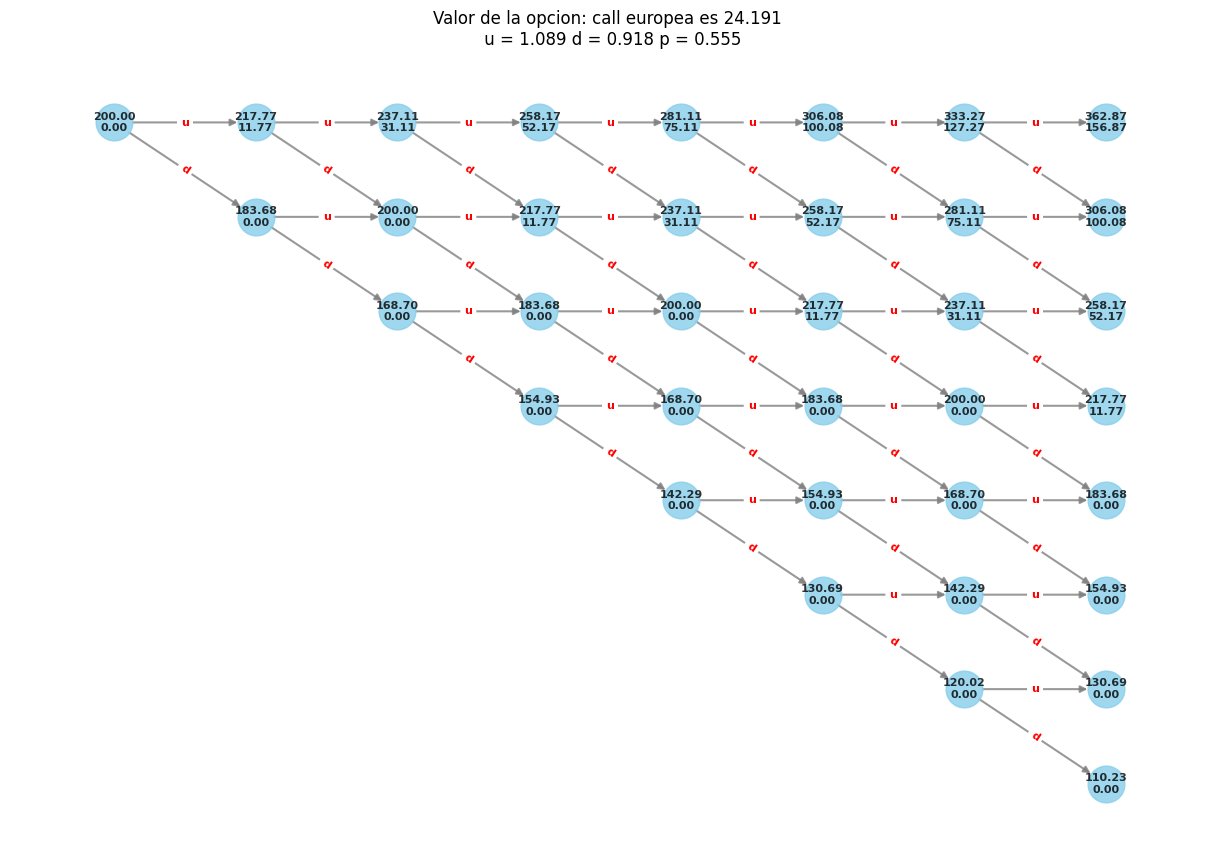

In [79]:
grafica = mod_bin_arbol(S, K, r, sigma, u, d, T, N, opcion)

In [68]:
df_precios_bin(60)

,Call europeo,Call americano,Put europeo,Put americano
0,23.942858,23.942858,12.212682,14.782934


In [72]:
df_precios_bs()

,Call europeo,Put europeo
0,23.887505,12.157329


**SE VERIFICA LA ECUACION DE PARIDAD**

In [ ]:
opcion_paridad = paridad_check_mb(S, K, r, sigma, u, d, T, N, opcion)
opcion_paridad

Put calculado con modelo binomial: 2.58187
Put calculado con ecuación de paridad: 2.58187
La ecuación de paridad se cumple.


,Datos,Valores
0,Call,3.373919
1,Put,2.581866
2,Paridad Call,3.373919
3,Paridad Put,2.581866


**BLACK & SCHOLES**

In [25]:
opcion_valuada_bs = black_scholes(S, K, T, r, sigma, opcion)
opcion_valuada_bs

23.88750473425098

**PARIDAD CON BLACK SCHOLES**

In [ ]:
opcion_paridad_bs = paridad_check_bs(S, K, T, r, sigma)
opcion_paridad_bs

Put calculado con modelo binomial: 2.96412
Put calculado con ecuación de paridad: 2.96412
La ecuación de paridad se cumple.


,Datos,Valores
0,Call,3.756176
1,Put,2.964123
2,Paridad Call,3.756176
3,Paridad Put,2.964123


**COMPARATIVA DE LOS MODELOS**

In [73]:
m = int(input('Ingrese los periodos deseados  '))
valores_K = []
valores_opcion_binomial = []
valores_opcion_black_scholes = []

for i in range(1, m + 1):
    valor_opcion_binomial = val_gral(S, K, r, sigma, u, d, T, i, tipo, opcion)
    valor_opcion_black_scholes = black_scholes(S, K, T, r, sigma, opcion)

    valores_K.append(i)
    valores_opcion_binomial.append(valor_opcion_binomial)
    valores_opcion_black_scholes.append(valor_opcion_black_scholes)


Ingrese los periodos deseados  60


**GRAFICA DE AMBOS MODELOS**

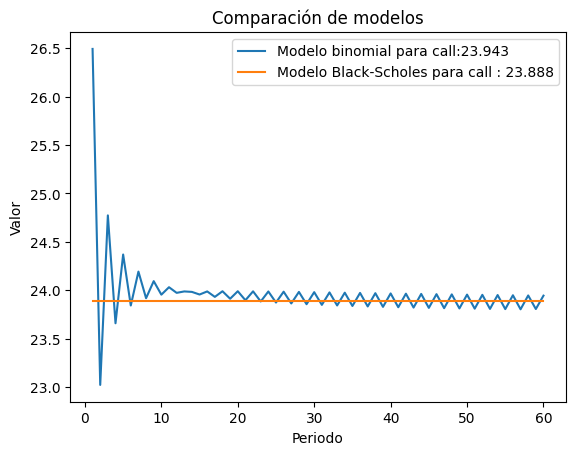

In [74]:
plt.plot(valores_K, valores_opcion_binomial, label=f'Modelo binomial para {opcion}:{valores_opcion_binomial[-1]:.3f} ')
plt.plot(valores_K, valores_opcion_black_scholes, label=f'Modelo Black-Scholes para {opcion} : {valores_opcion_black_scholes[-1]:.3f}')

plt.title('Comparación de modelos')
plt.xlabel('Periodo')
plt.ylabel('Valor')
plt.legend()
plt.show()


**NUMERO DE PERIODOS NECESARIOS PARA COMPARAR LOS DECIMALES**

In [77]:
grado = int(input('Ingrese el grado de error deseado: '))
analisis = n_necesarios(grado)
analisis

Ingrese el grado de error deseado: 2
Con 22 periodos se obtiene un error de precisión de 0.01


,Datos,Valores
0,N,22.000000
1,Margen,0.010000
2,Diferencia,0.007811
3,Black&Schols,23.887505
4,Modelo Binomial,23.895316
